<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/CIFAR10_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

#prepare dataset and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images-size: torch.Size([128, 3, 32, 32])


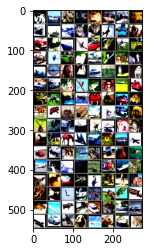

  dog  ship  frog plane  bird  ship   dog   dog  ship  ship plane   cat   cat plane truck   dog truck   cat  ship plane   car   cat horse  deer truck  bird   car   dog plane  bird horse  bird plane plane horse   dog   car  deer   cat   dog   car   car   dog  bird  frog   dog plane truck  frog  deer   dog plane truck plane   car  frog horse  frog  frog  frog  ship   dog truck   dog  deer  bird  deer  ship  deer  ship   dog  frog horse  deer horse plane   car  frog  ship plane   car   car   dog  ship  frog truck horse  deer plane  deer plane plane  deer truck  ship  frog   dog  bird   car plane  bird  deer horse   dog  frog   dog  bird  ship  bird horse  frog truck  frog plane  deer horse   car  deer   car   car  ship   car  bird   dog plane horse truck   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("images-size:", images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [ ]:
import torchvision.models as models
net=models.resnet18(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

#define ResNet18
net = ResNet18().to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1, verbose=False)

In [ ]:
import time
num_epoch=10

def train_and_test():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))

        net.train()
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs, labels = inputs.to(device), labels.to(device)
 
            #the gradient is increasing, so make it zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        #test
        net.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
 
                loss = criterion(outputs, labels)
 
                test_loss += loss.item() * inputs.size(0)
 
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
 
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
                test_acc += acc.item() * inputs.size(0)
 
        avg_train_loss = train_loss/ len(trainset)
        avg_train_acc = train_acc/ len(trainset)
 
        avg_test_loss = test_loss/len(testset)
        avg_test_acc = test_acc/len(testset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
 
        if best_acc < avg_test_acc:
            best_acc = avg_test_acc
            best_epoch = epoch + 1

        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tTest: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for test : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
          
    return history
    
#start training and testing
history = train_and_test()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

Epoch: 1/10
Epoch: 001, Training: Loss: 1.4593, Accuracy: 46.6140%, 
		Test: Loss: 1.1442, Accuracy: 58.9800%, Time: 30.7990s
Best Accuracy for test : 0.5898 at epoch 001
Epoch: 2/10


KeyboardInterrupt: ignored

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % (epoch+1))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    print('test')
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

for epoch in range(0,50):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 1
Loss: 1.437 | Acc: 47.546% (23773/50000)
test
Loss: 1.377 | Acc: 53.440% (5344/10000)

Epoch: 2
Loss: 0.935 | Acc: 66.656% (33328/50000)
test
Loss: 1.167 | Acc: 64.240% (6424/10000)

Epoch: 3
Loss: 0.713 | Acc: 75.042% (37521/50000)
test
Loss: 0.797 | Acc: 72.870% (7287/10000)

Epoch: 4
Loss: 0.589 | Acc: 79.576% (39788/50000)
test
Loss: 0.594 | Acc: 80.190% (8019/10000)

Epoch: 5
Loss: 0.510 | Acc: 82.236% (41118/50000)
test
Loss: 0.519 | Acc: 82.260% (8226/10000)

Epoch: 6
Loss: 0.456 | Acc: 84.062% (42031/50000)
test
Loss: 0.560 | Acc: 81.330% (8133/10000)

Epoch: 7
Loss: 0.416 | Acc: 85.532% (42766/50000)
test
Loss: 0.543 | Acc: 81.710% (8171/10000)

Epoch: 8
Loss: 0.382 | Acc: 86.662% (43331/50000)
test
Loss: 0.560 | Acc: 81.870% (8187/10000)

Epoch: 9
Loss: 0.340 | Acc: 88.196% (44098/50000)
test
Loss: 0.462 | Acc: 85.080% (8508/10000)

Epoch: 10
Loss: 0.319 | Acc: 88.844% (44422/50000)
test
Loss: 0.384 | Acc: 87.100% (8710/10000)

Epoch: 11
Loss: 0.295 | Acc: 89.892% (